# **Spectral clustering**

Spectral clustering is a family of clustering algorithms that use eigenvalues and eigenvectors to partition data into different classes. This family of algorithms inherits its name from the spectrum of a matrix, which is the set of its eigenvalues.

Spectral clustering is an unsupervised and transductive family of machine learning algorithms; it is unsupervised because data is not labeled or we do not know it a priori, and it is transductive because it is not usual to use spectral clustering to extend the results to never-seen data points [1].

Basically, spectral clustering algorithms consists on grouping datapoints based on the eigenvectors of a representative matrix. The general algorithm have the following steps:
1. Graph construction:  given $n$ data points, build a similarity graph.
2. Spectral embedding:  given a representative matrix, usually the Laplacian matrix, compute the first $k$ eigenvalues and eigenvectors.
3. Clustering: data is divided into k clusters 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import image
import scipy.sparse.linalg as sla
from scipy.sparse import coo_matrix

Let us introduce the following image

<Figure size 432x288 with 0 Axes>

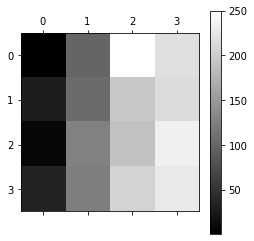

In [ ]:
Square = np.array([[1,100,250,218],[30,106,196,215],[8,127,189,235],[36,124,207,228]])
plt.figure()
plt.matshow(Square, cmap=plt.get_cmap('gray'))
plt.colorbar()

We know that there are three different classes, the pixels with blackish values, pixels with gray vlaues and pixels with whitish values. The question is, how does the computer knows how to group those pixels into two different segments?

We could think to segment by certain pixel value, which it is a fanastic idea. However, for more complex images it could be a problem. Or perhaps using a classification algorithm on the image. Nonetheless, some algorithms like KMeans rely on the fact that the pixel values do not have an underlying structure, like an image has.

Let us explain the algorithm.

## **1. Graph Construction**

The first part of any spectral clustering algorithm is Graph Construction. Let us introduce some graph notations and concepts.  

Let $G=(V,E,W)$ be a weighted undirected and connected graph with a set of vertices $V=\{v_1,v_2,\dots,v_n\}$ and a set of edges $E$ such that $e_{ij}=(v_i,v_j)$ an edge exists if the vertex $v_i$ is connected with $v_j$. It is called weighted graph because each edge $e_{ij}$ has a non-negative weight $w_{ij} \geq 0$. As $G$ is an undirected graph, $w_{ij}=w_{ji}$ is satisfied. We denote the adjacency matrix $W$ as:

$$w_{ij} = \left\{\begin{array}{rcl}s_{ij}& \mbox{if} & v_i \mbox{ and }v_j \mbox{ are connected}\\ 0  & \mbox{if} & v_i \mbox{ and }v_j \mbox{ are not connected}\end{array}\right.$$

The similarity measure is a function that calculates the closeness of pairwise data. In our case, we will use the Gaussian Radial Basis Function (RBF). The RBF is defined as:

$$s_{ij}=e^{-\frac{\|x_i-x_j\|_2^2}{\sigma^2}}$$

Where $\|.\|_2$ is the Euclidean distance, $\sigma$ is a parameter that controls the width of the neighborhoods. Usually, $\sigma$ is calculated as the $10-20\%$ of the distance of the two outermost points of the graph [2].

If we talk about images, they have an underlying structure. Pixels cannot move, they have a $\textit{rigid}$  neighbors. For example, the graph of our $4\times 4$ image  image should look like

$$\circ-\circ-\circ-\circ$$
$$|\quad\;\,|\quad\;\,|\quad\;\,|$$
$$\circ-\circ-\circ-\circ$$
$$|\quad\;\,|\quad\;\,|\quad\;\,|$$
$$\circ-\circ-\circ-\circ$$
$$|\quad\;\,|\quad\;\,|\quad\;\,|$$
$$\circ-\circ-\circ-\circ$$

where $\circ$ represent the vertices and $|$ or $-$ the edges. Such graph formation is called a 4 neighborhood graph. The center pixel has at most 4 adjacent pixels. Hence, the adjacecny matrix should be a $(4\times4)\times(4\times4)$ matrix. 

The $\textit{weighted}\,$ degree of a vertex, $d_{i}$, is calculated as the sum of the weighted edges incident to $v_i$

$$d_i = \sum_{j=1}^n w_{ij}$$

The Degree matrix has in its diagonal elements the degree of each vertex. Let us define the normalized Laplacian matrix

$$L= D^{-1/2}L_{un}D^{-1/2} =  I - D^{-1/2}WD^{-1/2}$$

The normalized Laplacian matrix is another way to represent a graph. It is a symmetric and positive semidefinite matrix. 

In [ ]:
# Initialize the graph with the 4-neighbor graph
graph = image.img_to_graph(Square)

# As Intensities can have values between 0-255, 
#we use the sigma value with 15% of 255
sigma = 255*0.15
graph.data = np.exp(-np.square(graph.data / sigma)/2) # This is called the Kernel Matrix

# Now, let us compute the adjacency Matrix
adjacency = graph.toarray()-np.diag(np.diag(graph.toarray()))

# With that info, let us calculate the Degree matrix
degree = np.matrix(np.diag(np.sqrt(np.power(adjacency.sum(axis=1),-1))))

# Now, let us compute the Normalized Laplacian
adjacency_normalized_cuts = np.matmul(degree,np.matmul(adjacency,degree))
L = np.matrix(np.eye(adjacency.shape[0]))-adjacency_normalized_cuts
Laplacian = coo_matrix(L)

## **2. Eigendecomposition**
At this stage, we have to calculate the eigenvalues and their corresponding eigenvectors of the normalized Laplacian matrix. With the eigenvectors corresponding to the $k$ smallest eigenvalues, we ensemble the eigenvector matrix $\textit{V}$ with $\textit{n}$ rows and $\textit{k}$ columns.

In [ ]:
# Use the 6 smallest 
eigenvalues, eigenvectors = sla.eigs(Laplacian, 6, which='SM') 

## **3. Clustering**
Once the eigenvalues and their corresponding eigenvectors were omputed, we have to calculate the corresponding graph cut. 

$\,$

For a bipartition of the graph, we can cluster the datapoints with the eigenvector corresponding to the second smallest eigenvalue of the Laplacian Matrix. In this work, we use the 0 as the threshold to cluster data points.

When we use the scipy function $\textit{eigs}$ we have to select the smallest eigenvalues and their corrsponding eigenvectors. However, sometimes this function throws the 6 smallest eigenvalues unsorted. Thus, we have to sort the eigenvalues and use the correct eigenvector. 

In [ ]:
# Let us initialize the V matrix with the same number of rows and columns
V = np.zeros(eigenvectors.shape)  # .shape throws the rows and columns
for i in range(eigenvectors.shape[0]): # number of rows
  for j in range(eigenvectors.shape[1]): # number of columns
    if eigenvectors[i,j] > 0:  # above 0 belongs to one cluster
      V[i,j] = 1
    else:
      V[i,j] = 0

# sort the eigenvalues
index = np.argsort(eigenvalues)

Now, let us see the original image and the segmented image

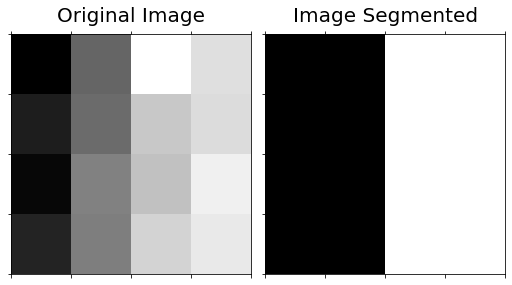

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (7,7), constrained_layout=True, sharey=True)
# show the clusters 
axs[0].matshow(Square, cmap=plt.get_cmap('gray'))
axs[1].matshow(V[:,index[1]].reshape(Square.shape), cmap=plt.get_cmap('gray'))
axs[0].set_title('Original Image', ha="center", va="center", color="k", fontsize=20, fontweight = 'medium')
axs[1].set_title('Image Segmented', ha="center", va="center", color="k", fontsize=20, fontweight = 'medium')
for i in range(2):
  axs[i].set_xticks(np.arange(-0.5,4.5))
  axs[i].set_yticks(np.arange(-0.5,4.5))
  axs[i].set_xticklabels([])
  axs[i].set_yticklabels([])
plt.show()

With the following functions we can know the cut size of the segmented image:

In [ ]:
import networkx as nx
import pandas as pd

def compute_edges(adjacency_matrix):
    edges = []
    for i in range(adjacency_matrix.shape[0]):
      for j in range(adjacency_matrix.shape[0]):
        if adjacency_matrix[i,j]!=0:
          edges.append((i,j))
    return edges

def create_network(adjacency_matrix, edges):
    # Identify working pixels
    number_of_pixels = adjacency_matrix.shape[0]

    # Populate a networkx graph with pixels as nodes.
    working_graph = nx.Graph()
    for node in range(number_of_pixels):
        working_graph.add_node(node)

    # Pair up all neighbors with random weights in working_graph.
    for pixel in edges:
        working_graph.add_edge(pixel[0], pixel[1], weight=adjacency_matrix[pixel[0], pixel[1]])

    #nx.draw_circular(working_graph, node_size=1000, with_labels=True)
    #plt.show()

    return working_graph, number_of_pixels

def compute_cut_size(labels, graph):
    df = pd.Series(labels)
    one_qubits = set(df[df==1].index)
    S_partition = set()
    T_partition = set()

    for node in graph:
        if node in one_qubits:
            # If a one was measured add node to S partition.
            S_partition.add(node)
        else:
            # Otherwise a zero was measured so add to T partition.
            T_partition.add(node)

    cut_size = nx.cut_size(
                graph, S_partition, T_partition, weight='weight')
    return cut_size


edges = compute_edges(adjacency_normalized_cuts)
nx_graph, pixels = create_network(adjacency_normalized_cuts, edges)
cut_size = compute_cut_size(V[:,index[1]], nx_graph)
print("Normalized Cut: ", cut_size)

Normalized Cut:  0.20751955387462745


# **Intuition behind the Laplacian Matrix**

Let us introduce why spectral clustering algorithms use the Lpalcian Matrix as the representative matrix. 

## **1. Adjacecny Matrix**
The adjacency matrix tells us which nodes are connected among them. The weighted adjacency matrix $W$ considers the weight of the edge connecting any two nodes. 

Let us multiply $W$ with a unit vector $x\in \mathbb{R}^n$, such that:
$$y=Wx$$
$$\mbox{element-wise}\quad y_i=\sum_j^{n}w_{ij}x_{j}$$

We can see the Adjacency Matrix from the image example here

In [ ]:
np.round(adjacency,3)

array([[0.   , 0.035, 0.   , 0.   , 0.75 , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.035, 0.   , 0.   , 0.   , 0.   , 0.988, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.705, 0.   , 0.   , 0.369, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.705, 0.   , 0.   , 0.   , 0.   , 0.997, 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.75 , 0.   , 0.   , 0.   , 0.   , 0.139, 0.   , 0.   , 0.848,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.988, 0.   , 0.   , 0.139, 0.   , 0.063, 0.   , 0.   ,
        0.86 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.369, 0.   , 0.   , 0.063, 0.   , 0.884, 0.   ,
        0.   , 0.983, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.997, 0.   , 0.   , 0.884, 0.   , 0.   ,
        0.   , 0.   , 0.87

We can see that this matrix is symmetric, thus it is invertible. For example, if we multiply this matrix with an *n* vector full of 1s, the result will be the degree $d_i$ of every node $v_i$.

In [ ]:
np.matmul(np.matrix(adjacency),np.matrix(np.ones((16,1))))

matrix([[0.78530603],
        [1.02333266],
        [1.07433497],
        [1.70165169],
        [1.73666084],
        [2.04955369],
        [2.2992607 ],
        [2.75309658],
        [1.62042055],
        [2.13376415],
        [2.63263128],
        [2.3408519 ],
        [0.83585914],
        [1.16278684],
        [1.8502386 ],
        [1.84348974]])

Let us present the following eigenproblem:

$$Wx=\lambda x $$

Basically, we want to find a vector $x$ that multiplying the adjacency matrix $W$ equals the same vector $x$ scaled $\lambda$ times. A trivial solution is the eigenvector 1, defined as $x=(1,\dots,1)$. Hence, multiplying the adjacency matrix $W$ with $x$ will turn into:

$$Wx = \left(\sum_{j}^{n}w_{ij},\sum_{j}^{n}w_{2j}, \dots,\sum_{j}^{n}w_{nj}\right) = (d_1,d_2,\dots,d_n)$$

Exactly as we observed in the example above. Where $d_ii$ is the degree of vertex $v_i$. Hence, if we have a fully connected graph, the eigenvalue would have a value of $\lambda_i=d_i$.

Let us have the segmented image from above. The graph representation would look like this
$$\mbox{A}\quad\quad\quad\quad\mbox{B}$$
$$\circ-\circ\quad\quad\circ-\circ$$
$$|\quad\;\,|\quad\quad\;\,|\quad\;\,|$$
$$\circ-\circ\quad\quad\circ-\circ$$
$$|\quad\;\,|\quad\quad\;\,|\quad\;\,|$$
$$\circ-\circ\quad\quad\circ-\circ$$
$$|\quad\;\,|\quad\quad\;\,|\quad\;\,|$$
$$\circ-\circ\quad\quad\circ-\circ$$

The graph has two subgraphs, A and B, with the same number of nodes. We say that this graph is not connected because there is not connection between A and B. If we want to find a solution to the eigenproblem ($Wx=\lambda x$), we can define two possible solutions (the trivial eigenvectors) as:
\begin{align*}
    x_1 &= (1,\dots,1,0\dots,0) \longrightarrow Ax_1 = (d_A,\dots,d_A,0\dots,0)\\
    x_2 &= (0,\dots,0,1\dots,1) \longrightarrow Ax_1 = (0,\dots,0,d_B\dots,d_B)
\end{align*}

Thus, the eigenvalue of both eigenvectors would be the degree of the vertices $\lambda=d_A=d_B=d$. However, we know that ther are connections between A and B. Here we can see their representation:

$$\mbox{A}\quad\quad\quad\mbox{B}$$
$$\circ-\circ\dots\circ-\circ$$
$$|\quad\;\,|\quad\;\,|\quad\;\,|$$
$$\circ-\circ\dots\circ-\circ$$
$$|\quad\;\,|\quad\;\,|\quad\;\,|$$
$$\circ-\circ\dots\circ-\circ$$
$$|\quad\;\,|\quad\;\,|\quad\;\,|$$
$$\circ-\circ\dots\circ-\circ$$

The new trivial eigenvectors and its corresponding eigenvalues are slightly different than the formal eigenvectors and eigenvalues. However, as the change is slightly different, the eigenvalues can be approximated as $\lambda\approx\lambda_A\approx\lambda_B$ because the desired cut will be the minimum cut.

## **2. Degree Matrix**

The degree matrix is a diagonal matrix whose entries are the degrees of every node $v_i$ in is diagonal. Let us multiply the degree matrix $D$ with a unit vector $x\in\mathbb{R}^n$:

$$y=Dx$$
$$\mbox{element-wise}\quad y_i=\sum_j^{n}d_{ij}x_j = x_jd_j $$

Then, multiplying $D$ with an unit vector $x$ with $x_j\neq0$ results in the vertex degree $d_j$ multiplied by the $x_j$ labels. 

In [ ]:
degree_matrix = np.diag(adjacency.sum(axis=1))
print(np.round(degree_matrix,3))

[[0.785 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    1.023 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    1.074 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    1.702 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.737 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    2.05  0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    2.299 0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    2.753 0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.62  0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    2.134 0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    

Now, let us think of the eigenvalue problem ($Dx=\lambda x$). A diagonal matrix has entries only in its main diagonal, hence each of its columns are their eigenvectors. As entries outside the main diagonal are zero, the eigenvalues of the diagonal matrix correspond to the value of the diagonal elements, that is $\lambda_i=d_i$ .

## **3. Laplacian Matrix**
Let us define the Laplacian Matrix as the following:

**Definition**
Given a weighted graph $G=(V,E,W)$ with vertices $V$ and edges $E$, we define the unnormalized Laplacian matrices as symmetric and positive semi-definite matrices that satisfies:

$$L_{un} = D-W $$

Where $D$ is the weighted degree matrix and $W$ is the weighted adjacency matrix. 

Let us multiply $L_{un}$ with a unit vector $x\in \mathbf{R}^n$:

$$y=L_{un}x=(D-W)x\nonumber$$
$$\mbox{element-wise}\quad y_i=\sum_j^{n}x_jd_{ij} -\sum_{j}^n x_jw_{ij}=x_j \sum_j^n w_{ij}- \sum_{j}^n x_jw_{ij}$$

After observing the Adjacency matrix and the Degree matrix, what happens when we multiply L with the vectior $x_1==(1,\dots,1)$? It yields the result:

$$y_i= 1\sum_j^n w_{ij}- \sum_{j}^n 1w_{ij}=0$$

If we think on the eigenvalue problem

$$L_{un}x=\lambda x$$

We see that the vector $x_1$ is an eigenvector, because it follows that $Lx_1=0x_1$. Hence, the corresponding eigenvalue is $\lambda_1=0$.


In [ ]:
unnormalized_laplacian = np.matrix(degree_matrix - adjacency)
print(np.round(unnormalized_laplacian,3))
print("\n\nLx' = \n", np.round(unnormalized_laplacian*np.matrix(np.ones((16,1))),3))

[[ 0.785 -0.035  0.     0.    -0.75   0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [-0.035  1.023 -0.     0.     0.    -0.988  0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.     1.074 -0.705  0.     0.    -0.369  0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.705  1.702  0.     0.     0.    -0.997  0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [-0.75   0.     0.     0.     1.737 -0.139  0.     0.    -0.848  0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.988  0.     0.    -0.139  2.05  -0.063  0.     0.    -0.86
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.369  0.     0.    -0.063  2.299 -0.884  0.     0.
  -0.983  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.997  0.     0.    -0.884  2.753  0.     0.
   0.    -0.872  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.848  0.     0.     0.     1.62  -0.008
   0.     0.  


How and why can we find a graph partition with the Laplacian matrix? Fiedler found a solution in his work [3] in 1973. We can make a bipartition of the graph with the second smallest eigenvalue and its corresponding eigenvector (also known as the Fiedler value and Fiedler vector, respectively).

By Rayleigh-Ritz Theorem, we know that the smallest non-zero eigenvalue can be computed by:

$$\lambda_2 = \mbox{min}\frac{f^TL_{un}f}{f^Tf}$$

where $f$ is any unit vector and $\lambda_2$ is the second smallest eigenvalue. Recall that the smallest eigenvalue $\lambda_1=0$. 

We know that the Laplacian matrices are positive semi-definite matrices, to prove it, let us compute $f^TL_{un}f$ 

\begin{align}
    f^TL_{un}f=f^TDf-f^TWf=\sum_i^n\sum_j^n f_i d_{ij}f_j - \sum_i^n\sum_j^n f_i w_{ij}f_j\\
     = \frac{1}{2}\Big(\sum_i^n \sum_j^n w_{ij} f_i^2 - 2\sum_i^n w_{ij}f_if_j + \sum_j^n \sum_i^n w_{ji} f_j^2\Big)\\
     = \frac{1}{2}\sum_{i,j}^n w_{ij}(f_i-f_j)^2
\end{align}

Hence, is a non-zero positive value. If we want to compute the second smallest eigenvector, then by definition $f$ must be orthogonal to the first eigenvector, $x_1=\textbf{1}$ vector, such that:

$$f^T\mathbf{1}=\sum_i^nf_i\textbf{1} = 0$$

In addition, by definition $f$ is a unit vector, so:

$$f^tf=\|f\|=1$$

Hence, the search for the second smallest eigenvalue is transformed is transformed into seeking the graph to have a balanced partition by minimizing the weights of each node

$$\lambda_2 = \mbox{min }\frac{1}{2}\sum_{i,j:e_{ij}\in E}w_{ij}(f_i-f_j)^2$$

Observe the term $(f_i-f_j)$, if we want the minimum value of $\lambda_2$, then $f_i$ and $f_j$ must be equal. This means that, if node $v_i$ and $v_j$ belong to the same subgraph, A or B, then it minimizes the eigenvalue. Otherwise, the eigenvalue is penalized. We reach to the optimal solution by defining the vector $f$ (Fiedler vector) as a binary vector such that:

$$f_i = \left\{\begin{array}{rcl}
      1& \mbox{if}&v_i\in A\\
      -1&\mbox{if}&v_j\in B 
 \end{array} \right.$$
 
However, restricting the vector $f_i$ to have only two values makes it computationally hard [4]. The solution is to allow $f_i$ to have real values. This relaxation makes graph cuts computationally easy to find. As an example, observe the eigenvalues and eigenvectors. If we state the threshold to be 0, it makes a \textit{successful} cut. This vector is the second eigenvector of the Laplacian Matrix.


In [ ]:
print("First 2 Eigenvalues: \n", np.real(np.round(eigenvalues[index[0:2]],3)))
print("\n\nFirst 2 Eigenvectors: \n", np.real(np.round(np.matrix(eigenvectors[:,index[0:2]]),3)))

First 2 Eigenvalues: 
 [-0.     0.036]


First 2 Eigenvectors: 
 [[ 0.168 -0.31 ]
 [ 0.192 -0.124]
 [ 0.196  0.165]
 [ 0.247  0.212]
 [ 0.25  -0.457]
 [ 0.271 -0.158]
 [ 0.287  0.208]
 [ 0.314  0.256]
 [ 0.241 -0.456]
 [ 0.277 -0.097]
 [ 0.307  0.19 ]
 [ 0.29   0.223]
 [ 0.173 -0.317]
 [ 0.204 -0.076]
 [ 0.258  0.167]
 [ 0.257  0.19 ]]


Note that the eigenvalues and eigenvectors were computed with the Normalized Laplacian (which we did not defined yet) instead of the Unnormalized Laplacian. You can observe that the second eigenvector produces the segmenation desired.

With the properties explained above, we can construct an alternative Linear Programming (LP) problem. Note that the search for the second eigenvalue is a minimization problem. This function is the objective to comply with.  Additionally, there are two restrictions: $f$ must be orthogonal to the eigenvector \textbf{1} and $f$ must be a unit vector. 

Nopw, with this information, we can formulate the LP problem:
\begin{equation}
\begin{array}{cc}
\mbox{min}&f^TL_{un}f\\
 \mbox{s.t.}& f\bot 1\\
 \,& \|f\|=1\\
\end{array}
\end{equation}
By relaxing $f_i$ to have real values, we relax the optimization problem.

Now, let us define the Normalized Laplacian Matrix and its LP problem.

**Definition** Given a weighted graph $G=(V,E,W)$ with vertices $V$ and edges $E$, we define the normalized Laplacian matrices as symmetric and positive semi-definite matrices that satisfies:

\begin{align}
     L_{un} = D^{-1/2}WD^{-1/2}
\end{align}

Where $D$ is the weighted degree matrix and $W$ is the weighted adjacency matrix. 

Its related LP can be formulated as 

\begin{equation}
\begin{array}{cc}
\mbox{min}_{\scriptscriptstyle A\subset V}&f^TL_{un}f\\
 \mbox{s.t.}& Df\bot 1\\
 \,& f'Df=vol(V)\\
 \,&f_i = \left\{\begin{array}{rcl}
      \sqrt{vol(\overline{A})/vol(A)}& \mbox{if}&v_i\in A\\
      -\sqrt{vol(A)/vol(\overline{A})}&\mbox{if}&v_i\in \overline{A} 
 \end{array} \right.
\end{array}
\end{equation}

where $vol(A)=\sum_{i\in A}d_i$

# **Graph Cut Segementation via QAOA** 

In 2019, Lisa Tse, et al. [5], proposed an algorithm for image segmentation using Quantum Approximate Optimization Algorithm (QAOA). This work is important because it formulates segmentation as a graph cut problem that can be mapped to the QAOA. Also it was one of the first image segmentation works made using spectral graph theory.

Before going into details about the algorithm, let us introduce the concepts of graph cut and the definition of Normalized Cuts.

Let $G=(V,E,W)$ be a weighted undirected and connected graph with a set of vertices $V=\{v_1,v_2,\dots,v_n\}$ and a set of edges $E$ such that $e_{ij}=(v_i,v_j)$ an edge exists if the vertex $v_i$ is connected with $v_j$. A Graph Cut is defined as:

$$\mbox{cut}(A,B)=\sum_{i\in A}\sum_{j\in B}w_{ij}$$

We expect to achieve an optimal partition when we find the minimum value of the cut. This problem is also called *MinCut*. Nonetheless, the drwback of the mincut is that it tends to make an unbalanced partition the graph, ie., it usually separates very few nodes from the graph.

There are two main ways to produce a balanced partition of a graph. RatioCut and NCut. *RatioCut* is a proposal from Hagen and Kahng [6] and it uses the Unnormalized Laplacian. *Ncut* is a proposal from Shi and Malik [2] that uses the Normalized Laplacian. 

This work uses NCut as its central point, which is defined as:

$$\mbox{NCut}(A,B)=\frac{cut(A,B)}{vol(A)}+\frac{cut(A,B)}{vol(B)}=cut(A,B)\left(\frac{1}{\sum_{i\in A}d_i}+\frac{1}{\sum_{i\in B}d_i}\right)$$






Knowing this, we can construct the Hamiltonian for the QAOA:

$$H_Z=\left(\sum_{e_{ij}\in E}-w_{ij}\sigma^z_i\sigma^z_j\right)\left(\sum_{i=0}^{2^n-1}|i\rangle\langle i|\left(\frac{1}{vol(A_i)}+\frac{1}{vol(B)}\right)\right)$$

where $|i\rangle$ is a bitstring, and $vol(A_i)$ and $vol(B_i)$ are computed according to the bitstring. For example, using the bistring {0001} we can infer that A has the nodes {1,2,3} and B has {4}.

## References

[1] Nicolas Tremblay and Andreas Loukas. Approximating  Spectral  Clustering  viaSampling: A Review, pages 129–183. Springer International Publishing, Cham,2020.

[2] Jianbo Shi and J. Malik. Normalized cuts and image segmentation. IEEE Transactions on Pattern Analysis and Machine Intelligence, 22(8):888–905, 2000.

[3] Miroslav Fiedler.  Algebraic connectivity of graphs. Czechoslovak  Mathematical Journal, 23(2):298–305, 1973.

[4] Ulrike von Luxburg. A tutorial on spectral clustering. Statistics and Computing, 17(4):395–416, Dec 2007.

[5] Lisa Tse, Peter Mountney, Paul Klein, and Simone Severini. Graph cut segmentation methods revisited with a quantum algorithm. CoRR, https://arxiv.org/abs/1812.03050.

[6] Lars Hagen and Andrew B. Kahng. New spectral methods for ratio cut partitionand clustering. IEEE Transactions on Computer-Aided Design, pages 1074–1085,1992